In [1]:
%load_ext autoreload
%autoreload 2
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import datetime
import torch
import matplotlib.colors as mcolors
from tqdm import tqdm

# Add parent directory to system path
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
sys.path.append(os.path.join(parent_dir, 'core'))

In [2]:
# Load the COMPAS dataset (adapted from https://github.com/aangelopoulos/gradient-equilibrium/blob/main/compas/debias.ipynb)
df = pd.read_csv('./raw_data/compas-scores-two-years.csv')
df = df[['compas_screening_date', 'sex', 'race', 'v_decile_score', 'is_recid']]
df = df[df.race.isin(["African-American", "Caucasian", "Hispanic"])]
df.compas_screening_date = pd.to_datetime(df.compas_screening_date)

# drop rows after 2014-04-01 (keep rows on or before this date)
cutoff = pd.Timestamp('2014-04-01')
df = df[df.compas_screening_date <= cutoff]

df_req = (
    df.assign(compas_screening_date=pd.to_datetime(df['compas_screening_date']))
    .sort_values('compas_screening_date')
    .set_index('compas_screening_date')
)

df_req['p_tilde'] = df_req['v_decile_score'] / 10.0

In [3]:
# Output directory for plots
plots_dir = os.path.join(os.getcwd(), "plots")
os.makedirs(plots_dir, exist_ok=True)


Plotting moving averages:
African-American: plotting 422 daily points from 2013-01-01 to 2014-04-01
Caucasian: plotting 421 daily points from 2013-01-01 to 2014-04-01
Hispanic: plotting 293 daily points from 2013-01-01 to 2014-04-01


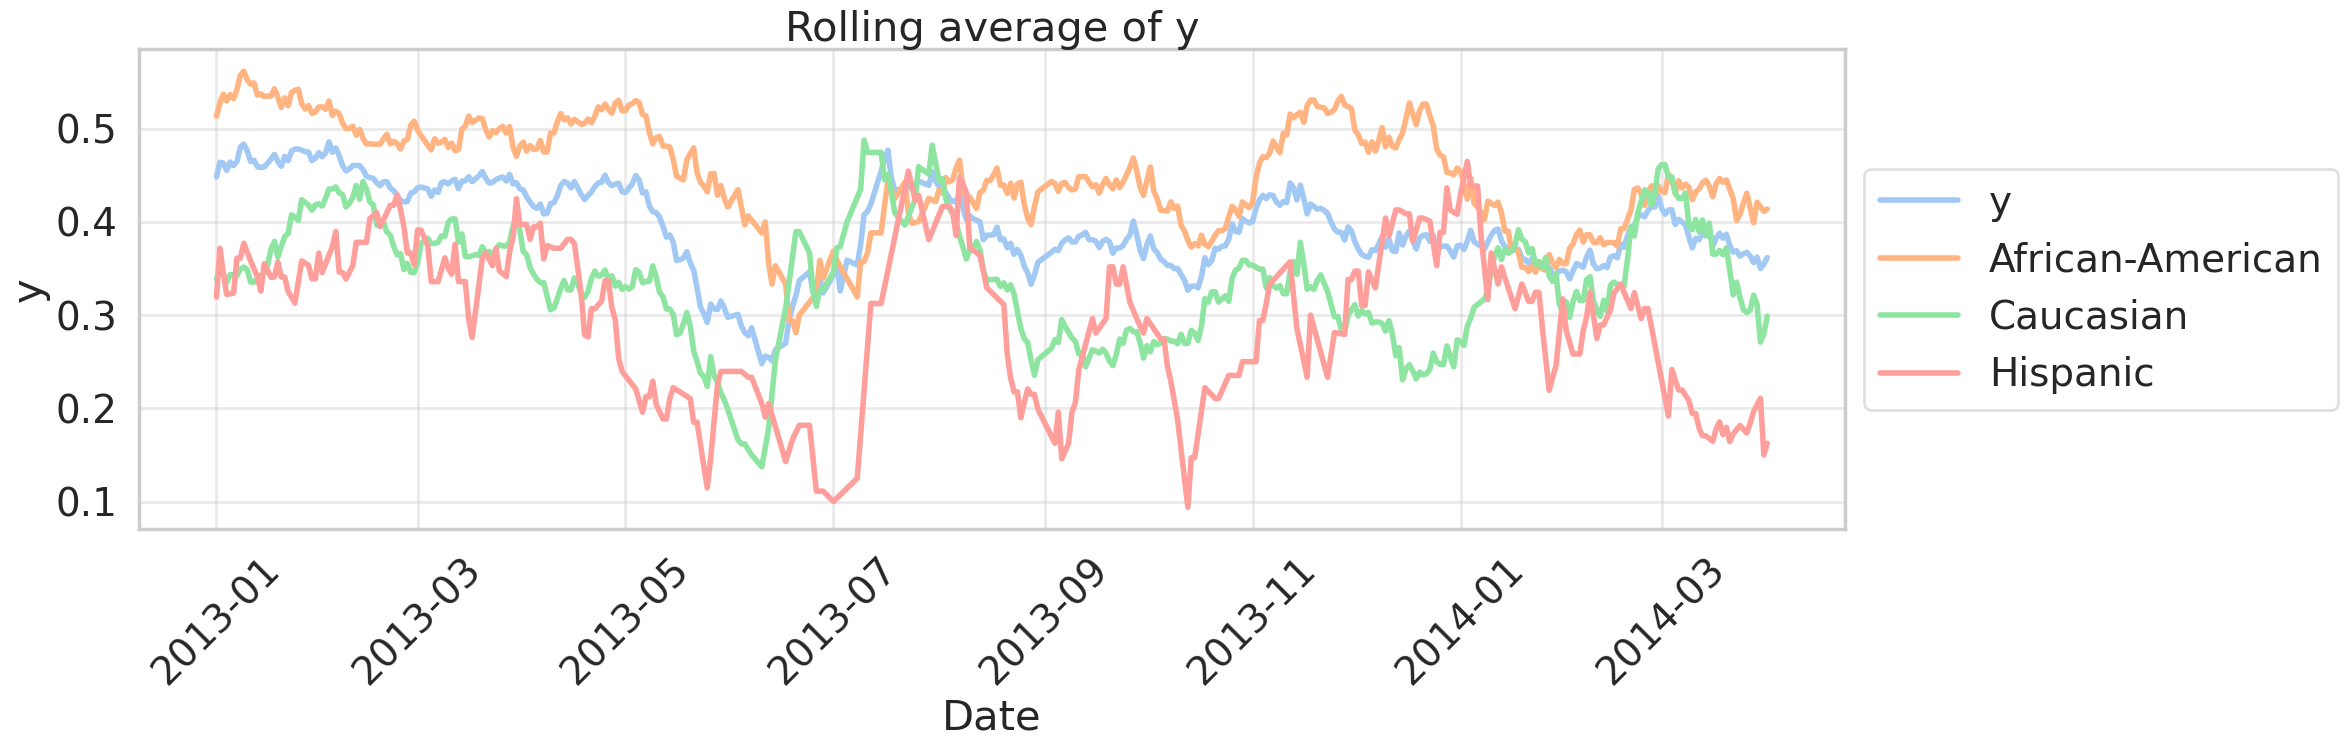

In [ ]:
sns.set_style("whitegrid")
sns.set_context("poster")
sns.set_palette("pastel")

print(f"\nPlotting moving averages:")
fig, ax = plt.subplots(figsize=(24, 8))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Blue, Orange, Green

# Plot moving averages for all race groups
window_str = "30D"   

# Overall: daily average, then time-based rolling 
# Collapse to one point per calendar day (mean over all individuals that day)
daily_all = (
    df_req["is_recid"]
    .groupby(df_req.index.normalize())   # normalize() strips time; groups by date
    .mean()
    .sort_index()
)

# Plot y moving averages
y_ma = daily_all.rolling(window=window_str, center=True, min_periods=1).mean()
ax.plot(y_ma.index, y_ma.values, linewidth=4, label="y")

# Per-race moving averages
races = df_req["race"].astype("category")
order = list(races.cat.categories)

for race in order:
    race_df = df_req[df_req["race"] == race]

    if race_df.empty:
        print(f"{race}: no data; skipping.")
        continue

    # one value per date for this race
    daily_race = (
        race_df["is_recid"]
        .groupby(race_df.index.normalize())
        .mean()
        .sort_index()
    )
    # time-based rolling window over dates
    daily_roll = daily_race.rolling(window=window_str, center=True, min_periods=1).mean()

    # Drop NaNs and plot
    npts = daily_roll.notna().sum()
    start = daily_roll.index.min().strftime("%Y-%m-%d")
    end   = daily_roll.index.max().strftime("%Y-%m-%d")
    print(f"{race}: plotting {npts} daily points from {start} to {end}")
    ax.plot(daily_roll.index, daily_roll.values, linewidth=4, label=f"{race}")

ax.set_xlabel("Date", fontsize=30)
ax.set_ylabel("y", fontsize=30)
ax.set_title("Moving average of recidivism rate", fontsize=30)
ax.tick_params(axis="x", rotation=45, labelsize=28)
ax.tick_params(axis="y", labelsize=28)

fig.subplots_adjust(right=0.9)  # make room on the right for the legend
ax.legend(loc="center left", bbox_to_anchor=(1.0, 0.5), frameon=True, framealpha=0.6, ncol=1, fontsize=28)

ax.grid(True, alpha=0.4)

plt.tight_layout()
fig.savefig(os.path.join(plots_dir, "y_moving_avg.pdf"), bbox_inches="tight")
plt.show()